# DB backends experiments

## Description

Several experimetns on GO DB backends were performed in order to measure disk usage and operation times. 

## Util functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os

In [6]:
class Step:
    def __init__(self, name, du, records, duration, sysmem):
        self.name = name
        self.du = du
        self.records = records
        self.duration = duration
        self.sysmem = sysmem
        
    def __str__(self):
        return f"Step({self.name}, {self.du}, {self.records}, {self.duration}, {self.sysmem})"
    
    def __repr__(self):
        return f"Step({self.name}, {self.du}, {self.records}, {self.duration}, {self.sysmem})"
    
    def parse_from_tokens(tokens):
        if len(tokens) != 5:
            raise Exception("Incorrect line")
        name = tokens[0]
        du = int(tokens[1])
        records = int(tokens[2])
        duration = int(tokens[3].split('.')[0])
        sysmem = int(tokens[4])
        return Step(name, du, records, duration, sysmem)
        
    def parse_from_file(file_path):
        steps = []
        with open(file_path) as f:
            for ln in f.readlines():
                tokens = ln.strip().split()
                if len(tokens) == 0:
                    continue
                if tokens[0] in ['insert', 'delete', 'initial', 'batchInsert', 'batchDelete']:
                    steps.append(Step.parse_from_tokens(tokens))
        return steps

In [16]:
def draw_experiment(experiment_name):
    measurementsDIR = "measurements"
    files = [f for f in os.listdir(measurementsDIR) if os.path.isfile(os.path.join(measurementsDIR, f))]
    files = list(filter(lambda f: f.startswith(experiment_name), files))
    n = len(files)
    
    fig, axs = plt.subplots(n, 4, figsize=(15, 4 * n))
    axs = np.resize(axs, (n, 4))
    
    for i, file in enumerate(files):
        backend = re.split('_|\.', file)[1]
        steps = Step.parse_from_file(os.path.join(measurementsDIR, file))
        draw_steps(axs[i], steps, backend)
        
    plt.tight_layout()
    plt.show()
        

def draw_steps(ax, steps, backend):
    durations = [step.duration for step in steps]
    dus = [step.du for step in steps]
    records = [step.records for step in steps]
    sysmems = [step.sysmem for step in steps]
    x = [i for i in range(len(steps))]
    
    ax[0].text(-1, 0.5, backend, transform=ax[0].transAxes, va="center", fontsize=18)
    
    ax[0].plot(x, durations) 
    ax[0].set_xticks(x)
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Durations")
    
    ax[1].plot(x, dus) 
    ax[1].set_xticks(x)
    ax[1].set_xlabel("Steps")
    ax[1].set_ylabel("Disk usage MiB")
    
    ax[2].plot(x, records) 
    ax[2].set_xticks(x)
    ax[2].set_xlabel("Steps")
    ax[2].set_ylabel("Records")
    
    ax[3].plot(x, sysmems) 
    ax[3].set_xticks(x)
    ax[3].set_xlabel("Steps")
    ax[3].set_ylabel("SysMem MiB")

## Experiments

Each experiment is run in steps. Each step either inserts or deletes a number of random key-value pairs.

For each backend we plot 4 metrics against steps:
* __Duration__: time in seconds the step took
* __Disk usage__: disk space in MiB the storage occupies after the step
* __Records__: number of records in DB after the step
* __SysMem__: memory in MiB the process uses after the step. See 

### Small fluctuations
In this experiment we first fill the storage to the size of 5GiB, then perform "fluctuations", namely alternating inserts and deletions of 1GiB chunks. 
 * Key size: 64B
 * Value size: 1MiB
 * Initial storage size: 5GiB
 * Inserted/deleted volume per step: 1GiB

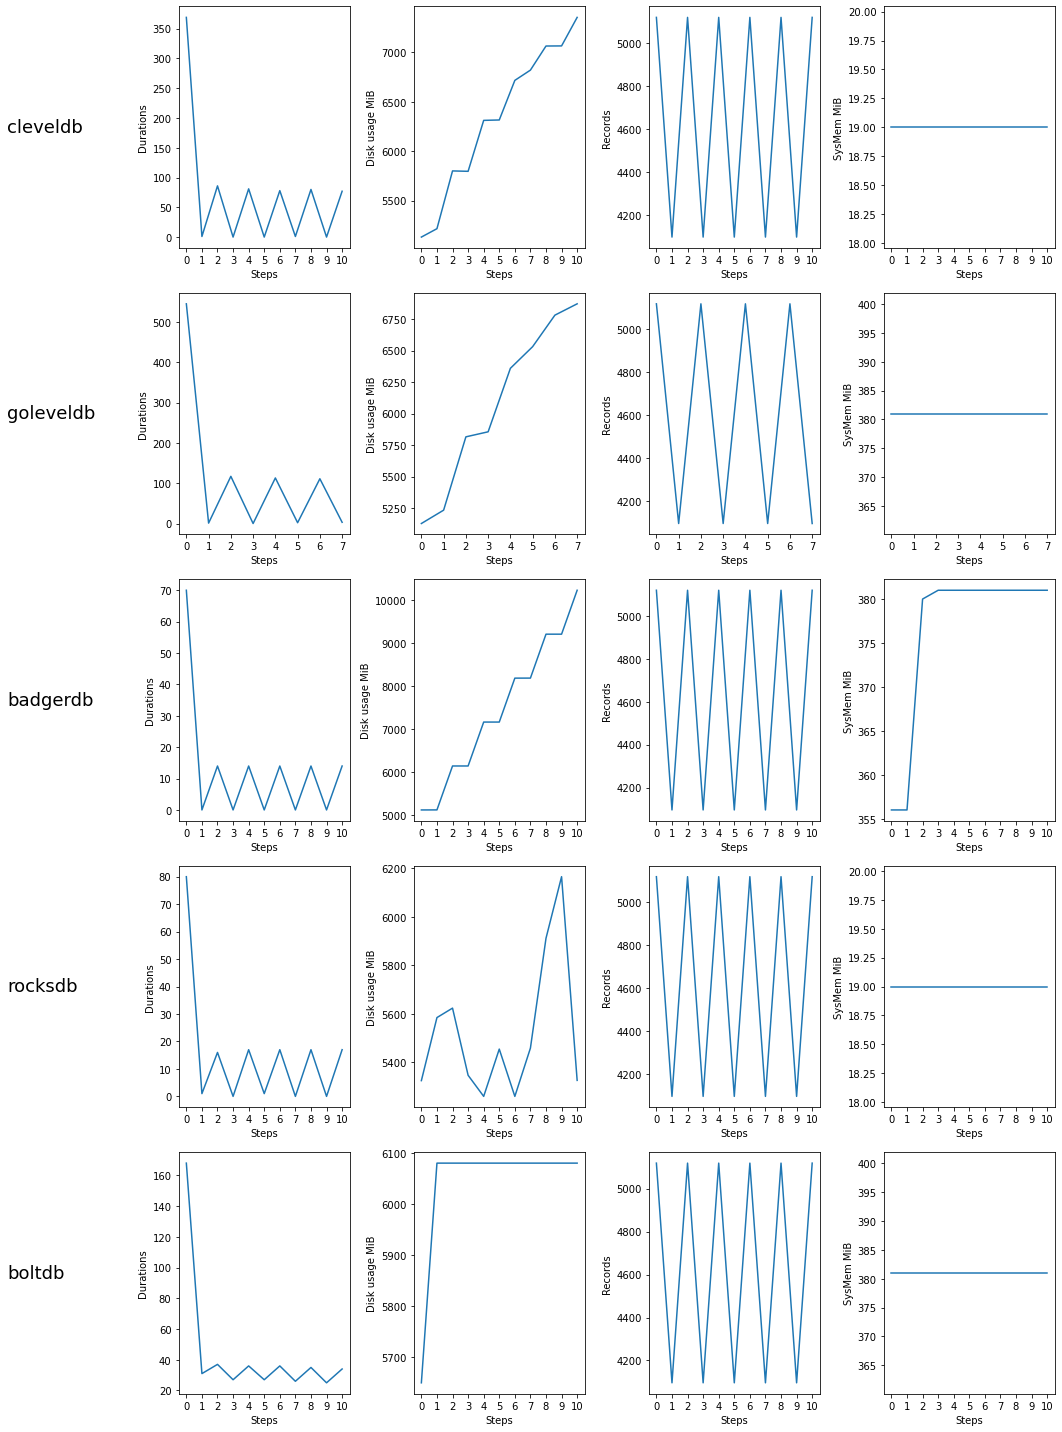

In [10]:
draw_experiment("BenchmarkSmallFluctuations")

#### Analysis
* For __cleveldb__, __goleveldb__, and __badgerdb__ the storage size constanly grows

### Small inserts
In this experiment we perform simple inserts to DB. 
 * Key size: 64B
 * Value size: 1MiB
 * Inserted volume per step: 1GiB
 * Total storage goal: 10GiB

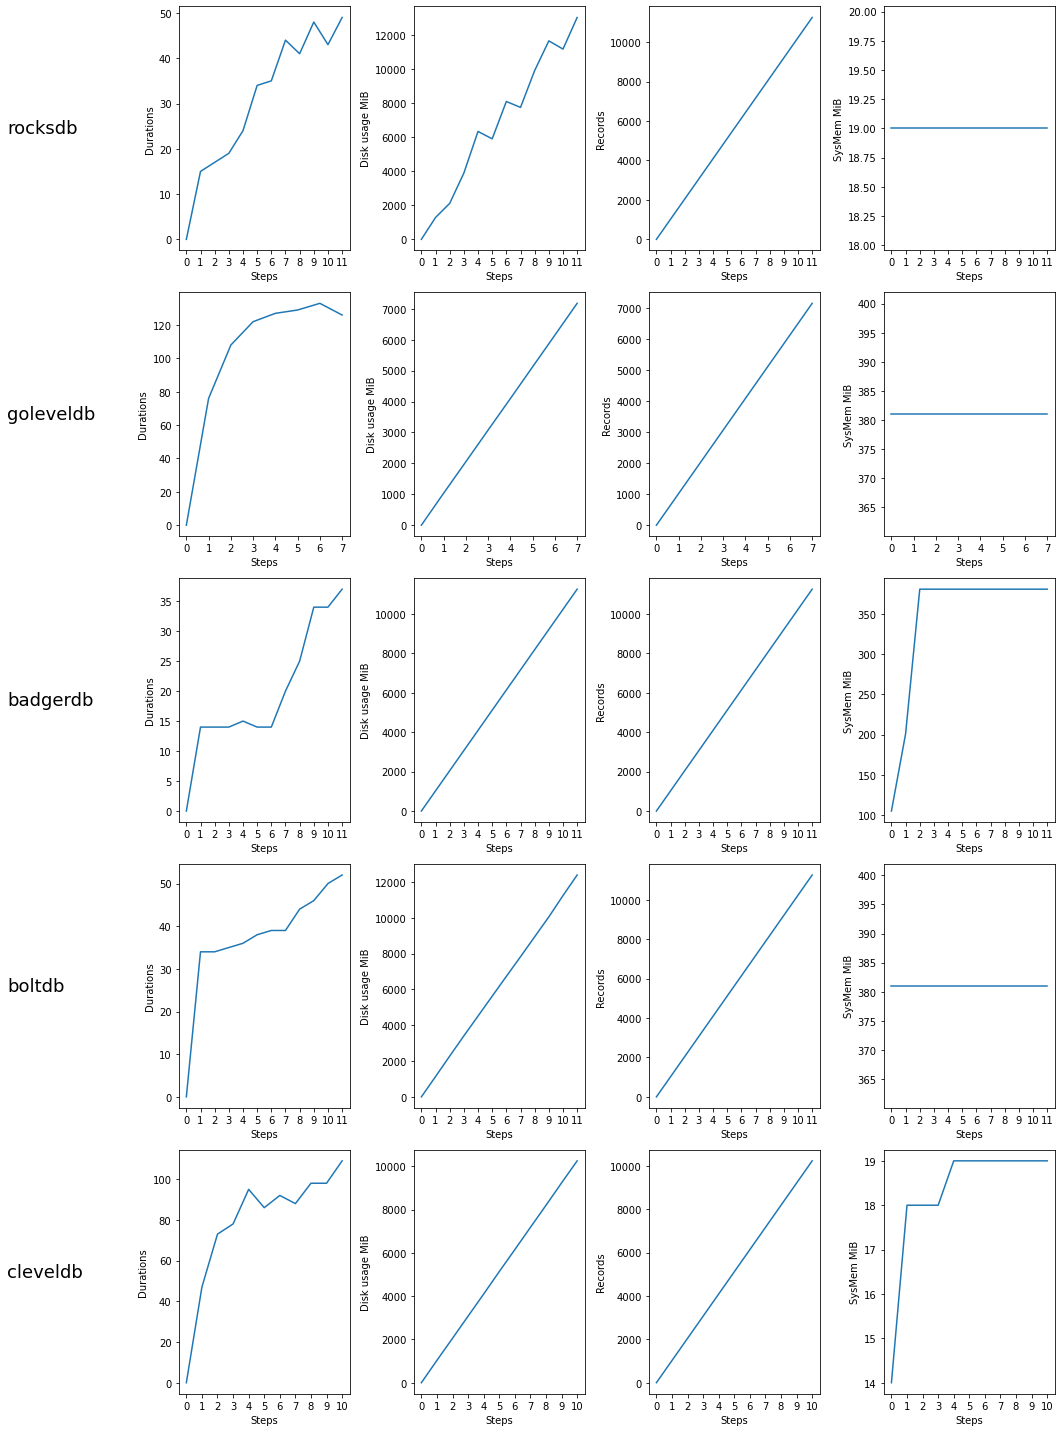

In [7]:
draw_experiment("BenchmarkSmallInserts")

#### Analysis
There are several points to note:
* For each backend the insertion time increases with a number of records present in the DB
* __cleveldb__ and __goleveldb__ are substantially slower
* __rocksdb__ disk usage does not 1 to 1 correspond with the actuall volume stored. Note that the result disk usage of __rocksdb__ is approximately 13GiB 
* The previous point also holds for __boltdb__

### Medium inserts
In this experiment we perform simple inserts to DB. 
 * Key size: 64B
 * Value size: 64MiB
 * Inserted volume per step: 1GiB
 * Total storage goal: 10GiB

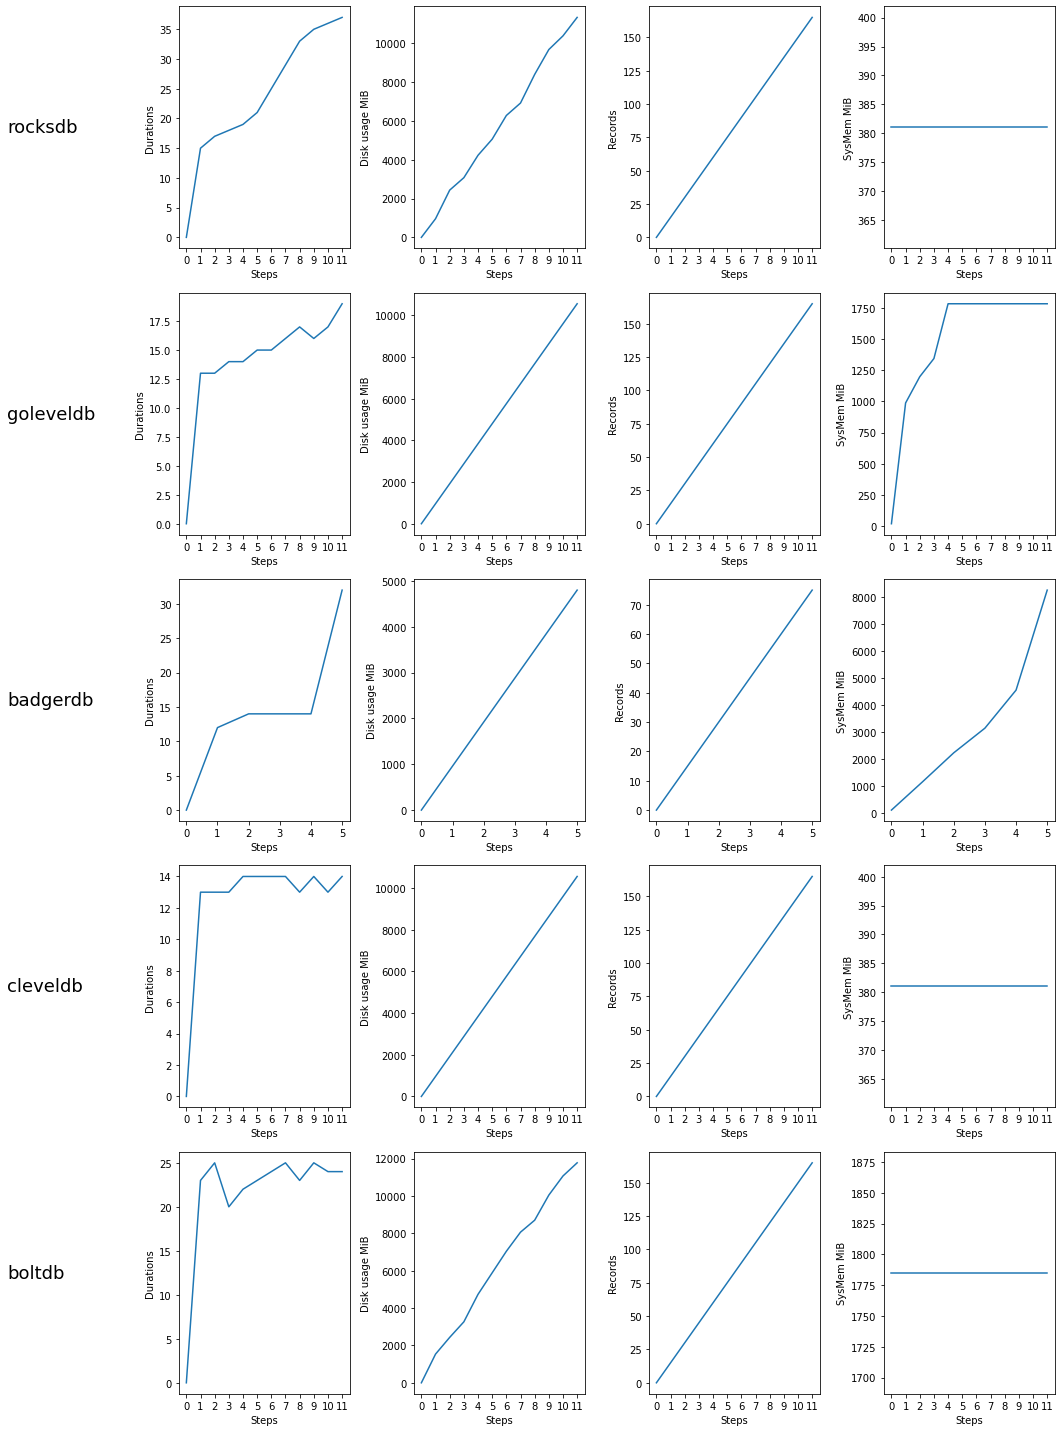

In [5]:
draw_experiment("BenchmarkMediumInserts")

#### Analysis
* __badgerdb__ consumed a tramendous amount of system memory and was forcefuly stopped
* __cleveledb__ and __goleveldb__ perform steps faster than others, which especially interesting since they were substantially slower for small writes
* __boltdb__ disk usage is greater than the actuall volume stored

If we don't iterate over the DB to calculate records, __badgerDB__ performs great

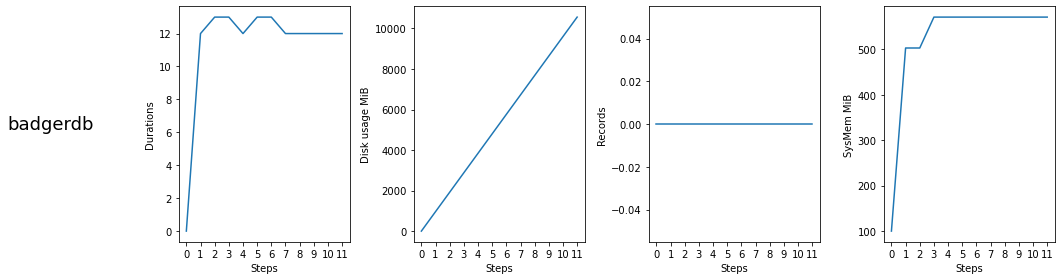

In [6]:
draw_experiment("BenchmarkMediumInsertsNoIterator")

### Large inserts
In this experiment we perform simple inserts to DB. 
 * Key size: 64B
 * Value size: 512MiB
 * Inserted volume per step: 1GiB
 * Total storage goal: 10GiB

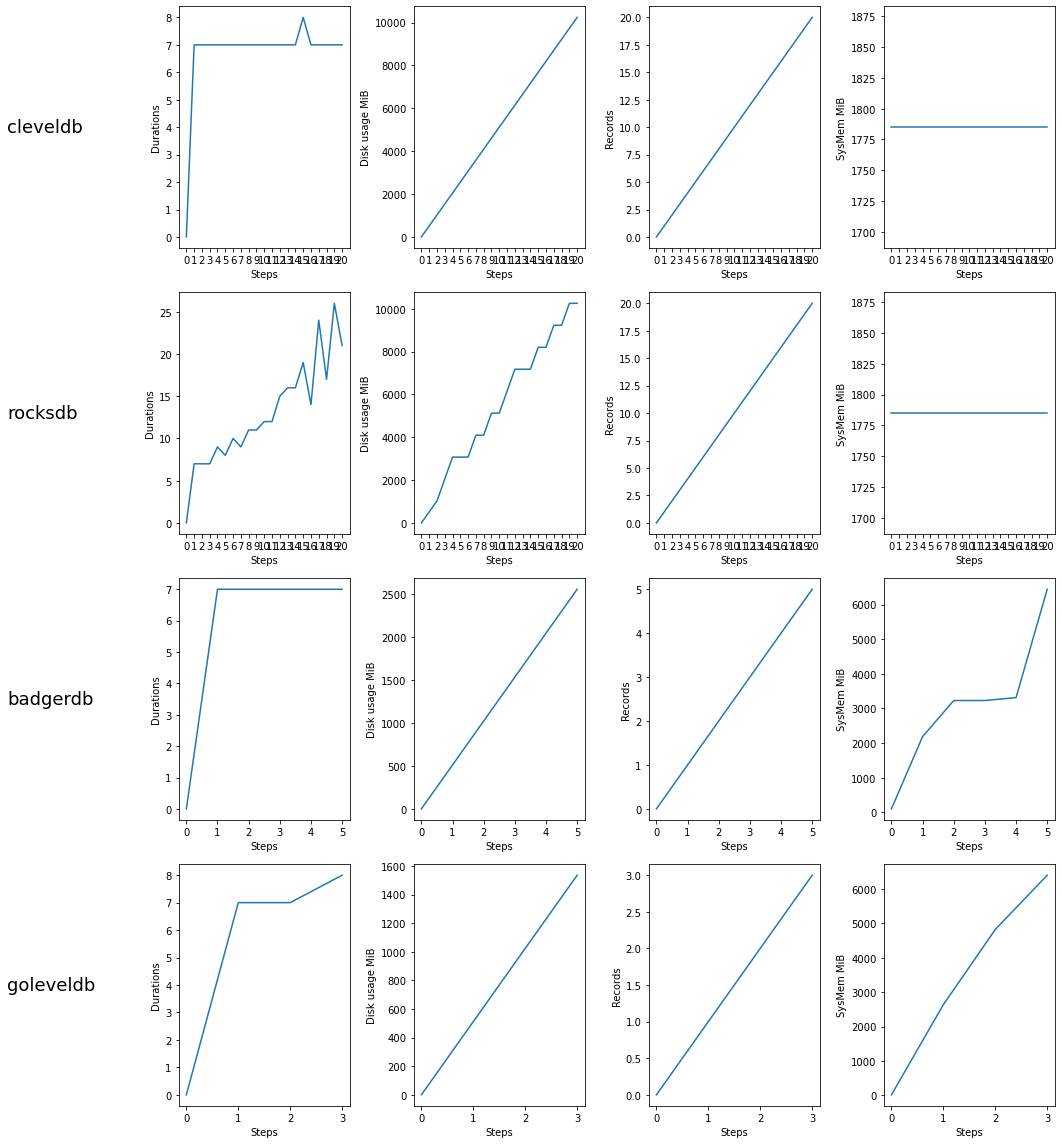

In [6]:
draw_experiment("BenchmarkLargeInserts")

#### Analysis
* __boltdb__ encountered int32 overflow. Reproduced in `misbehavior_test.go:TestBoltDBInt32Overflow`
* __badgerdb__ and __goleveldb__ ran out of system memory 

If we don't iterate over the DB to calculate records, __badgerDB__ performs great, but __goleveldb__ still fails.

Memory profiler for __goleveldb__ outputs the following space allocation percentage:
* __40%__: [Put](https://github.com/syndtr/goleveldb/blob/126854af5e6d8295ef8e8bee3040dd8380ae72e8/leveldb/db_write.go#L374)
* __37%__: [mCompaction](https://github.com/syndtr/goleveldb/blob/126854af5e6d8295ef8e8bee3040dd8380ae72e8/leveldb/db_compaction.go#L766)

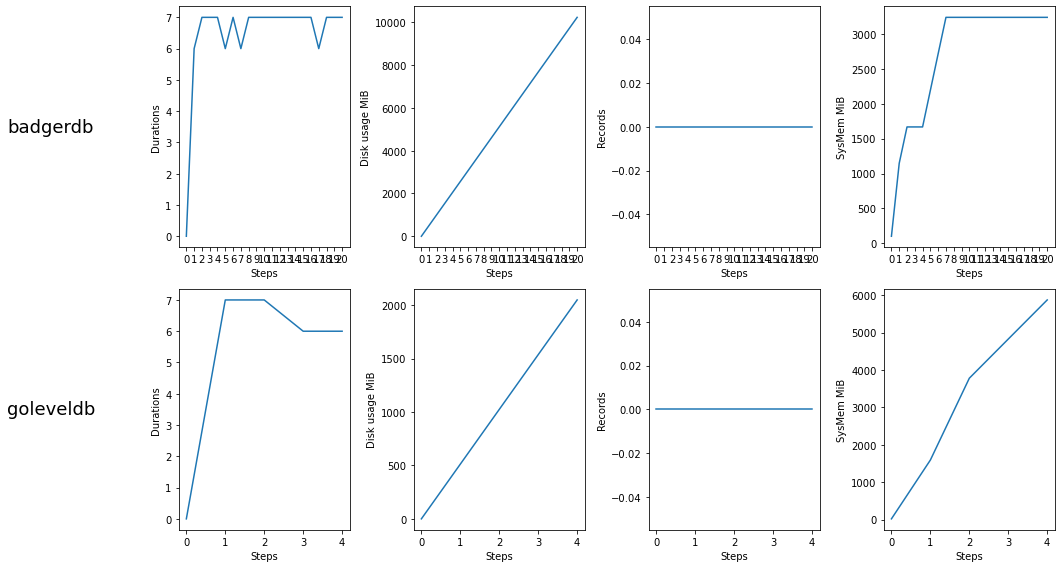

In [7]:
draw_experiment("BenchmarkLargeInsertsNoIterator")

## Small deletions
In this experiment we perform simple deletions from DB after filling it to ~10GiB. 
 * Key size: 64B
 * Value size: 1MiB
 * Deleted volume per step: ~1GiB
 * Initial storage size: ~10GiB

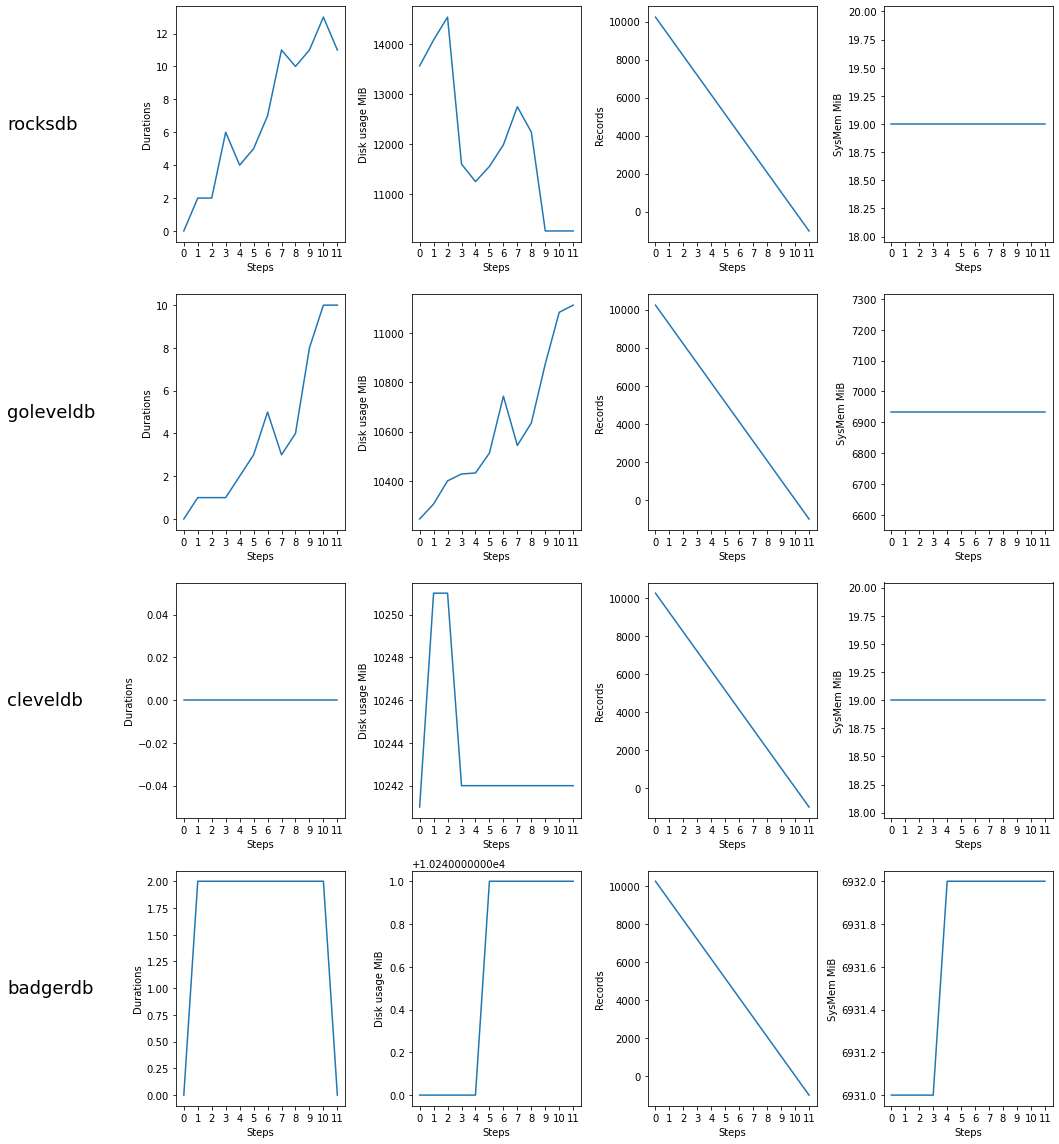

In [12]:
draw_experiment("BenchmarkSmallDeletions")

#### Analysis
* None of the backends perform real deletion from the disk
* Deletion time for __cleveldb__ and __badgerdb__ is neglectible, whereas for __rocksdb__ and __goleveldb__ it is ~10sec/step
* Deleting can actually cause disk usage growth. For __goleveldb__ it has been almost 1GiB
* __boltb__ was not able to finish within an hour. The issue is reproduced in  
`misbehavior_test.go:TestBoltDBDeletions:`
* I have no clue what happened for steps 1-4 for __badgerdb__...

## Small batch inserts
In this experiment we perform batched inserts in DB filling it to ~10GiB. 
 * Key size: 64B
 * Value size: 1MiB
 * Inserted volume per step: ~1GiB
 * Target storage size: ~10GiB

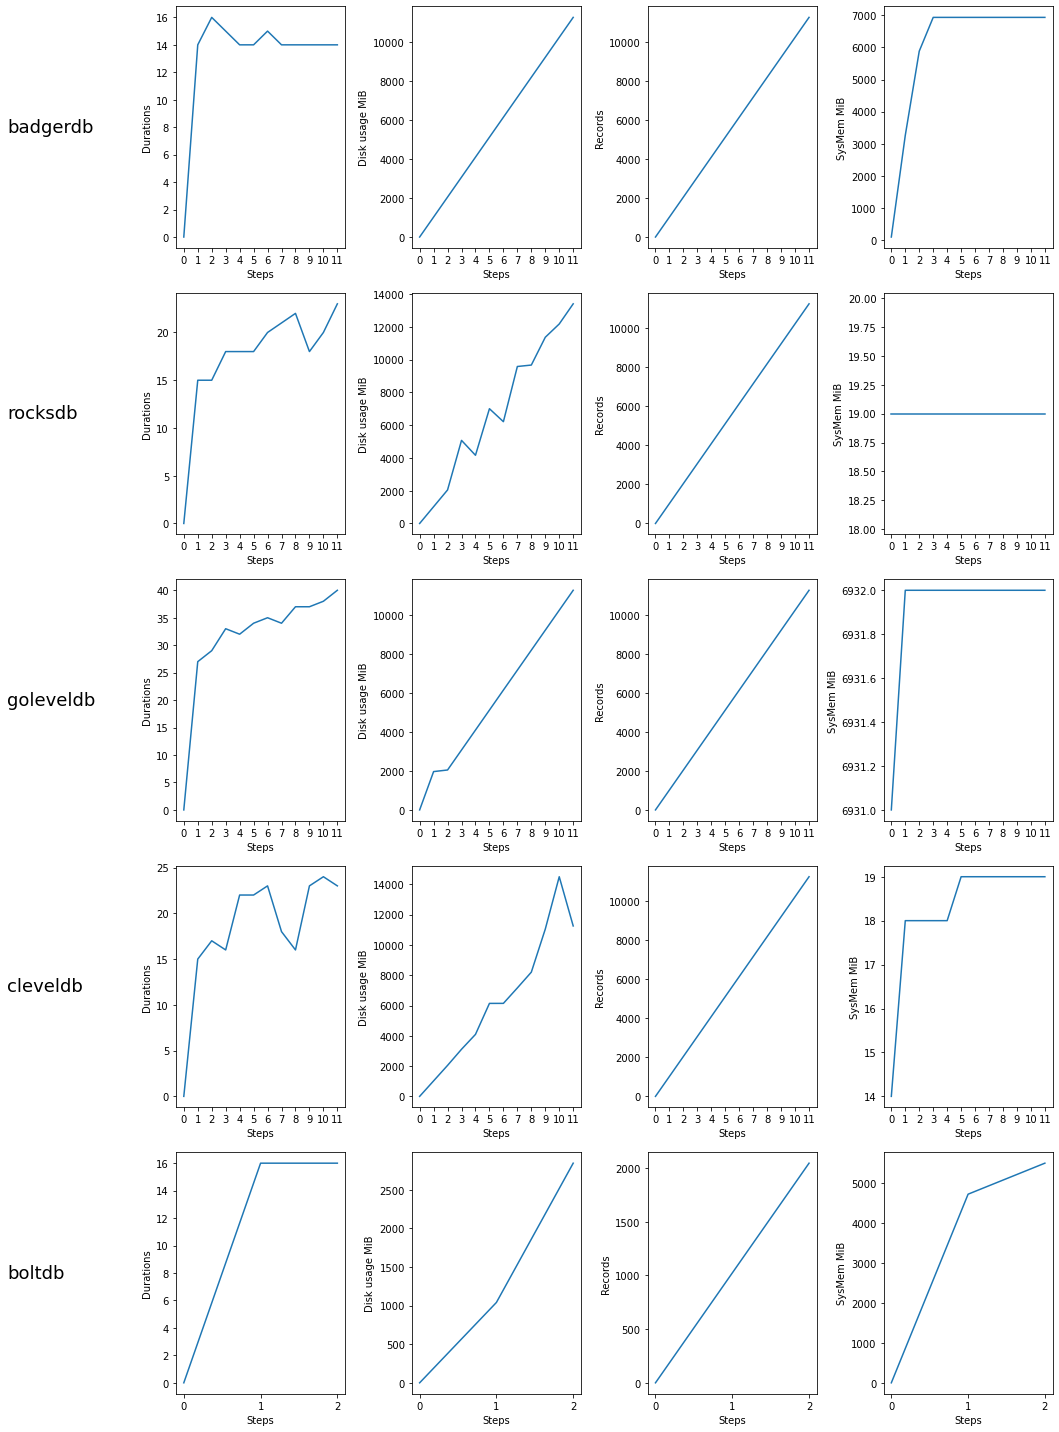

In [9]:
draw_experiment("BenchmarkSmallBatchInserts")

#### Analysis
* __boltdb__ used to much of a system memory and was forcefuly stopped
* Time improvement is noticable. It's 2 to 4 times fatser depending on the backend with the best gain of ~4x at __cleveldb__ 
* __goleveldb__ and __badgerdb__ require an immense amount of ssytem memory
* __cleveldb__ disk usage is non-monotone and exceeds the bare volume need by a factor of ~1.3 

## Small batch deletions
In this experiment we perform batched deletions from DB after filling it to ~10GiB. 
 * Key size: 64B
 * Value size: 1MiB
 * Deleted volume per step: ~1GiB
 * Initial storage size: ~10GiB

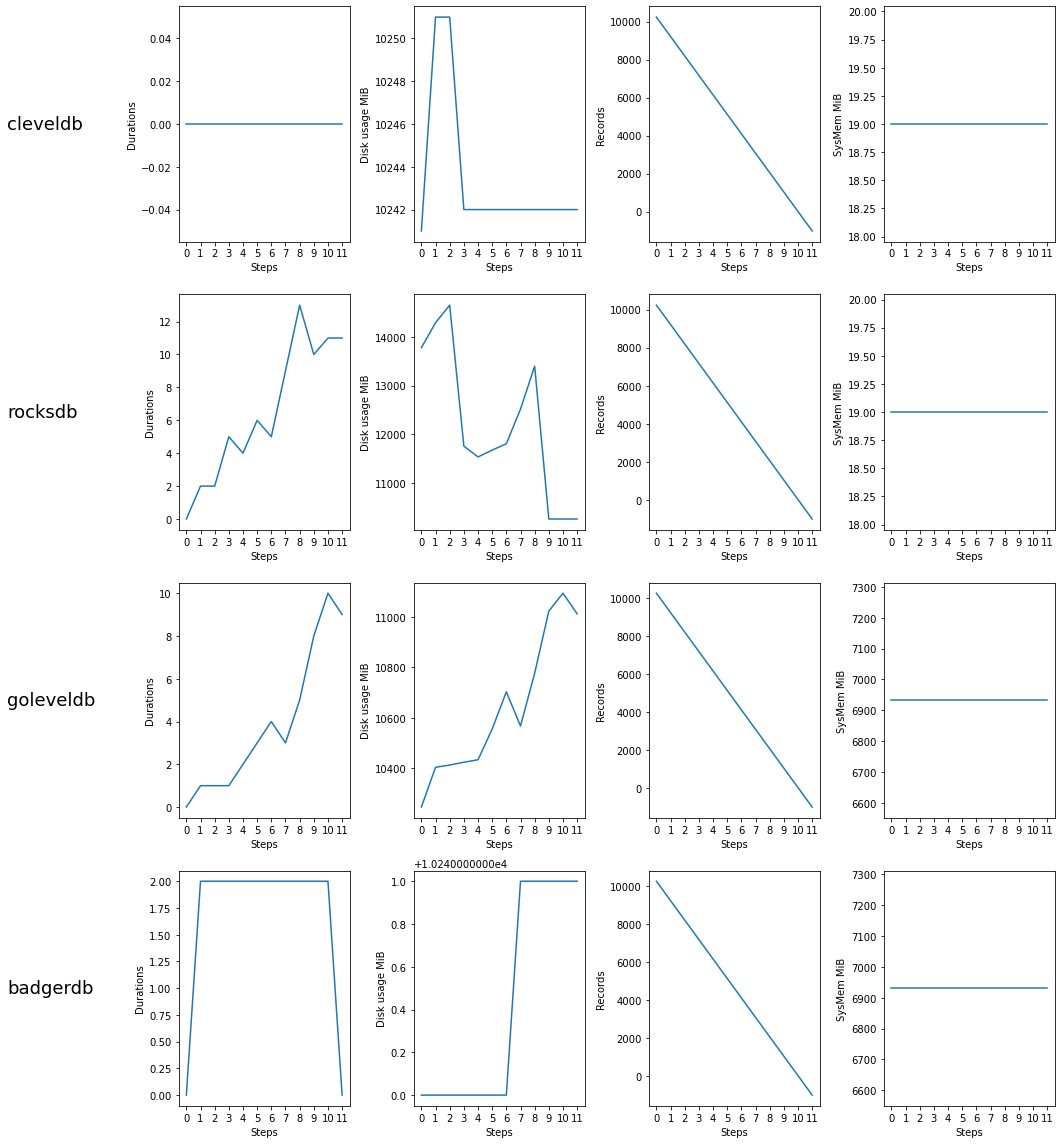

In [18]:
draw_experiment("BenchmarkSmallBatchDeletions")

#### Analysis
The plots are almost identical to those with no batching